In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cpi
plt.style.use('ggplot')

df = pd.read_csv('../data/Prices_E_All_Data.csv',encoding = "ISO-8859-1")

def clean_columns(df):
    cols = df.columns
    cols = [col.lower().replace(' ', '_') for col in cols]
    new_cols = []
    for col in cols:
        if col[0] == 'y':
            new_cols.append(col[1:])
        else:
            new_cols.append(col)
    df.columns = new_cols
    return df

def remove_flags(df):
    cols = df.columns
    lst = []
    for col in cols:
        if col[-1] == 'f':
            lst.append(col)
    df = df.drop(lst,axis=1)
    return df

def get_USD_prices(df,crop):
    prices = df[(df['item'] == crop) & (df['unit']=='USD')]
    return prices

def adjust_prices(df):
    years = df.columns
    for i in range(26):
        df[years[i+7]]=df[years[i+7]].apply(lambda x: cpi.inflate(x,int(years[i+7])))
    return df

In [35]:
df = clean_columns(df)
df = remove_flags(df)
usd = get_USD_prices(df,'Cloves')
adjusted = adjust_prices(usd)
print(adjusted)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


       area_code        area  item_code    item  element_code  \
11091        101   Indonesia        698  Cloves          5532   
14324        129  Madagascar        698  Cloves          5532   
22380         38   Sri Lanka        698  Cloves          5532   

                          element unit         1991         1992         1993  \
11091  Producer Price (USD/tonne)  USD  5940.100171  2509.459192  2445.903824   
14324  Producer Price (USD/tonne)  USD   904.132693   735.602117   817.270741   
22380  Producer Price (USD/tonne)  USD  5396.588104  4785.172311  3086.791447   

        ...           2008         2009         2010          2011  \
11091   ...     489.377748   491.593245   587.646761           NaN   
14324   ...            NaN          NaN          NaN           NaN   
22380   ...    5185.001555  4863.144699  5884.989236  12126.398752   

              2012         2013          2014        2015         2016    2017  
11091          NaN          NaN           NaN       

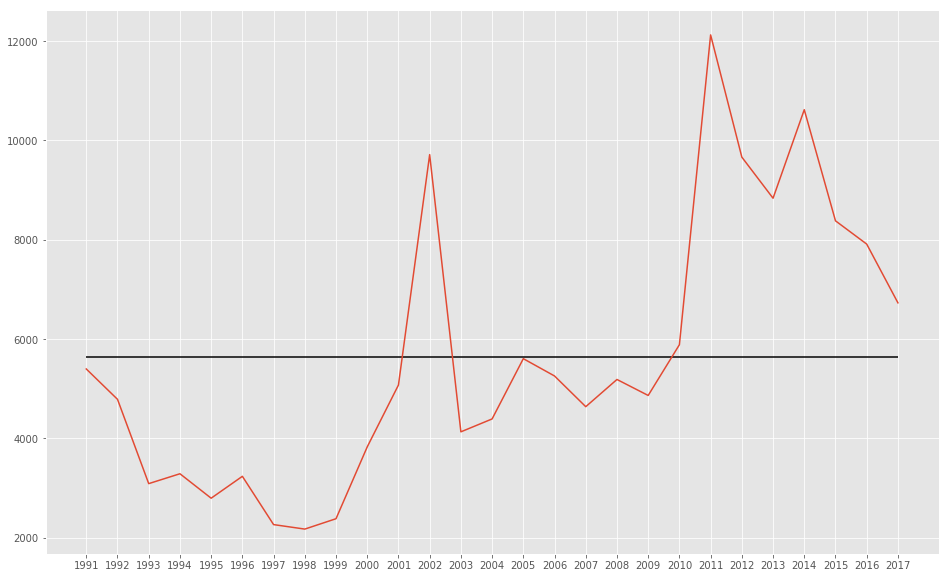

In [36]:
fig,ax = plt.subplots(figsize=(16,10))
plt.plot(adjusted.iloc[2,7:])
plt.hlines(np.mean(adjusted.iloc[2,7:]),xmin=0,xmax=26)

In [37]:
adjusted.iloc[:,7:]

,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
11091,5940.100171,2509.459192,2445.903824,2183.377059,1826.786948,1767.831690,1642.443169,751.626413,1084.010531,3690.339634,...,489.377748,491.593245,587.646761,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14324,904.132693,735.602117,817.270741,994.261725,714.600432,748.679762,476.399262,2548.042810,5516.817776,5360.011614,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22380,5396.588104,4785.172311,3086.791447,3285.740178,2793.153454,3233.982887,2261.371077,2170.920150,2379.939694,3826.975672,...,5185.001555,4863.144699,5884.989236,12126.398752,9664.372304,8836.286281,10619.563829,8381.07501,7912.360049,6729.1


In [57]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# read in csv
df = pd.read_csv('../data/Production_Crops_E_All_Data_NOFLAG.csv', encoding = "ISO-8859-1")

# clean column names
cols = df.columns
cols = [col.lower().replace(' ', '_') for col in cols]
new_cols = []
for col in cols:
    if col[0] == 'y':
        new_cols.append(col[1:])
    else:
        new_cols.append(col)
df.columns = new_cols

df = df[df['area_code']<1000]
df = df[df['area'] != 'China, mainland']

def yield_cagr(df):
    yield_df = df.loc[df['element'] == 'Yield']
    print(yield_df[['1961','2017']][(yield_df.item=='Cloves')])
    grouped = yield_df.groupby('item').mean()
    print(grouped.loc['Cloves', '2017'])
    grouped['cagr'] = (grouped['2017']/grouped['1987'])**(1/30) - 1
    return grouped

In [58]:
df = yield_cagr(df)


         1961     2017
6310      NaN  13911.0
7624      NaN   2756.0
15728  3500.0   2258.0
18089     NaN  10141.0
19939  3143.0   3281.0
20358  2500.0   2296.0
30660  2500.0  10160.0
34529  3800.0  12789.0
7199.0


In [68]:
std = np.std(df['cagr'])
m = np.mean(df['cagr'])
print(m)
print(std)

0.008983989468500531
0.009555588660358742


In [67]:
dist = stats.norm(loc=m,scale=std)
1-dist.cdf(.039)

0.000841286817384379

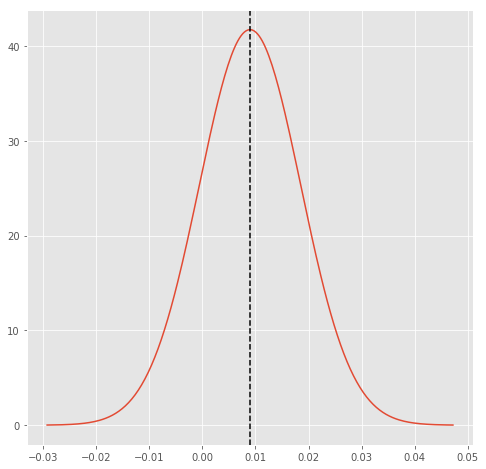

In [61]:
fig,ax = plt.subplots(figsize=(8,8))
x = np.linspace((m-4*std), (m+4*std), num=250)
y = dist.pdf(x)
ax.plot(x,y)
ax.axvline(m,color='black',linestyle='--')

In [62]:
bootstrap = np.random.choice(df['cagr'], size=df.shape[0], replace=True)
bootstrap
np.nanmean(bootstrap)

0.009349175070377152

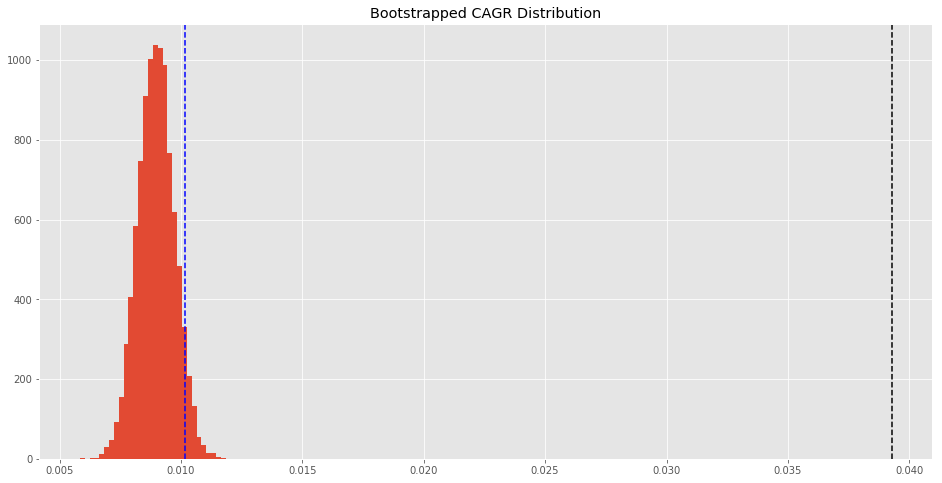

In [75]:
bootstrap_means = []
for i in range(10000):
    bootstrap = np.random.choice(df['cagr'], size=df.shape[0], replace=True)
    bootstrap_means.append(np.nanmean(bootstrap))
fig,ax = plt.subplots(figsize=(16,8))
plt.hist(bootstrap_means,bins=30)
ax.set(title='Bootstrapped CAGR Distribution')
ax.axvline(df.loc['Cloves','cagr'],color='black',linestyle='--')
ax.axvline(df.loc['Vegetables Primary','cagr'],color='blue',linestyle='--')

In [69]:
print(df.loc['Cloves','2017'])
print(df.loc['Cloves','1997'])
print(df.loc['Cloves','cagr'])

7199.0
2903.75
0.03926752125986965


In [45]:
df.head()

,area_code,item_code,element_code,1961,1962,1963,1964,1965,1966,1967,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,cagr
item,,,,,,,,,,,,,,,,,,,,,
Agave fibres nes,95.750000,800.0,5419.0,9492.500000,9015.666667,9192.000000,9203.166667,9132.166667,9086.000000,9205.333333,...,8184.125000,8063.250000,7944.375000,7766.750000,7913.500000,7644.500000,7477.500000,7526.125000,7442.000000,-0.017011
"Almonds, with shell",144.510204,221.0,5419.0,18133.800000,18472.133333,17908.466667,19829.133333,18555.466667,18306.000000,23345.866667,...,15196.170213,17128.659574,18029.042553,20286.063830,23719.255319,19010.872340,20382.065217,21329.391304,21248.195652,0.013621
"Anise, badian, fennel, coriander",142.317073,711.0,5419.0,10144.384615,10533.153846,10515.615385,12003.428571,12818.000000,13173.500000,13853.857143,...,13773.894737,14373.868421,13700.473684,12987.447368,14371.157895,13286.684211,14531.473684,15115.578947,16377.342105,0.021660
Apples,132.690000,515.0,5419.0,129624.888889,137922.400000,131038.422222,143902.955556,134858.155556,143607.090909,163652.318182,...,149146.148936,146620.138298,151295.234043,141807.819149,154065.936170,163306.872340,165082.382979,157015.361702,152125.563830,0.009154
Apricots,135.000000,526.0,5419.0,65467.483871,62443.064516,68556.548387,67435.903226,71379.612903,69255.096774,78493.225806,...,69358.014706,63100.970588,69643.955882,67730.852941,69634.779412,67737.544118,73579.676471,68339.558824,71730.955882,0.010020


In [ ]:
df[df['item']=='Cloves']